In [3]:
%matplotlib inline

In [1]:
import numpy as np
import os
#import sys, h5py, binascii

import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh
#from pygimli.meshtools.mesh import exportHDF5Mesh
#from pygimli.meshtools import convertMesh

In [ ]:
#Def des paramètres de géométrie du modéle
xmin,xmax = 0, 40 # en cm
emin,emax = 0, 80 #  elevation en cm
dtrou = 30 # prof du trou en cm
etrou = emax - dtrou # elevation du fond du trou
r=2 # rayon du trou en cm
dx = .1 #On définit le pas de la maille
zaff= 20 #profondeur en cm jusqu'où on souhaite un maillage affiné. 
eaff=etrou-zaff

assert dtrou + zaff < emax

xtrou_reg = np.arange(xmin, r + dx, dx, 'float')
etrou_reg = np.arange(etrou, emax + dx, dx, 'float')


efin_reg = np.arange(eaff, etrou + dx, dx, 'float')
h_0=-95 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1=10 #hauteur d'eau au fond du trou en cm

In [ ]:
etrou_reg[len(etrou_reg)-2:0:-1];

In [5]:
#A présent on crée une zone grâce à un polygone

poly = pg.Mesh(2)  # empty 2d mesh
nStart = poly.createNode(r, emax, 0.0) #On crée un noeud de départ, on travaille en 2D donc le dernier terme vaut 0.0

nA = nStart #On définit le noeud de départ
for e in etrou_reg[len(etrou_reg)-2:0:-1]: #On démarre du haut et on se balade sur l'axe des z en créant un noeud à chaque fois
    nB = poly.createNode(r, e, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée

nB = poly.createNode(r, etrou, 0.0) #On crée un noeud    
poly.createEdge(nA, nB)
nA = nB
    
for x in xtrou_reg[len(xtrou_reg)-2:0:-1]:
    nB = poly.createNode(x, etrou, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nB = poly.createNode(0, etrou, 0.0) #On crée un noeud    
poly.createEdge(nA, nB)
nA = nB

for e in efin_reg[len(efin_reg)-2:0:-1]: #On démarre de 1 et on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly.createNode(0, e, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nC = poly.createNode(0.0, 0.0, 0.0)
poly.createEdge(nB, nC)
nD = poly.createNode(xmax, 0.0, 0.0)
poly.createEdge(nC, nD)
nE = poly.createNode(xmax, emax, 0.0)
poly.createEdge(nD, nE)
poly.createEdge(nE, nStart) #On ferme le polygone!

tri = pg.TriangleWrapper(poly) #On appelle la fonction triangle
tri.setSwitches('-pzeAfaq31')
# Ici on a :
# p : planar straight line graph ==> fichier poly
# z : on démarre le comptage à 0
# A : assigne un attribut à chaque triangle qui indique à quel segment il appartient et est lié
# f : algorithme de triangulation (?)
# a : impose une surface contrainte pour chaque triangle on peut ajouter un nombre si on veut préciser
# q31 : impose que les triangles générés aient au minimun des angles de 20° On peut ajouter un nombre derrière pour préciser le nombre que l'o souhaite

In [6]:
#A présent on génère le maillage hétérogène

mesh = pg.Mesh(2) #On appelle le second maillage autour du premier
tri.generate(mesh) #On génère les triangles au sein du polygone précédemment crée

In [7]:
for cell in mesh.cells(): #On génère les cellules de chaque maille
    cell.setMarker(2)
    

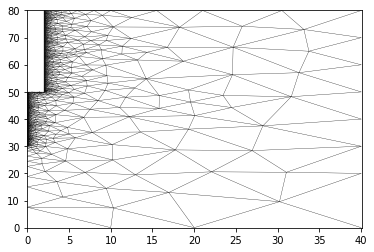

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3b86bfbbe0>, None)

In [8]:
showMesh(mesh)

In [ ]:
print(mesh_pos.shape)
print(mesh_pos)

In [11]:
mesh.boundaries() #utiliser la tabulation pour lister les operations possibles sur un objet. mesh.'tab par exemple

mesh.cellCount()
mesh.nodeCount()

1868

In [ ]:
for c in mesh.cells():
    print([[node.x(),node.y()] for node in c.nodes()])
    

In [14]:
#c=mesh.cell(0) renvoie la cellule 0

def crossprod(c):

    node0=c.node(0)
    a0=np.array([node0.x(),node0.y()])
    node1=c.node(1)
    a1=np.array([node1.x(),node1.y()])
    node2=c.node(2)
    a2=np.array([node2.x(),node2.y()])

    #faire un produit vectoriel entre node[1]-node[0] et node[2]-node[0]. 
    return np.cross(a1-a0,a2-a0)

crossprod(mesh.cell(0))
# si négatif, node[1],node[2]=node[2],node[1]
# afficher node[0] node[1] node[2]
#c.boundaryNodes

array(0.021433447398304162)

In [15]:
f=open("maillage.txt","w")

for c in mesh.cells(): 
    assert crossprod(c) > 0 # arrete tout si c'est faux.
    for node in c.nodes():
        #f.write(str([[node.x(),node.y()]]))
        f.write("{} {} \n".format(node.x(),node.y()))
f.close()
    

In [31]:
f=open("maillage.txt","w")

for node in mesh.nodes():
    f.write("{} {} \n".format(node.x(),node.y()))
f.close()
    

In [ ]:
!cat maillage.txt

In [ ]:
!head -686 maillage.txt

In [35]:
c=mesh.cell(0)
print(c)

<class 'pygimli.core._pygimli_.Triangle'>	ID: 0, Marker: 2, Size: 0.010716723699152081
	559 RVector3: (0.171279466666, 38.85, 0.0)
	685 RVector3: (0.107533776285, 38.75, 0.0)
	1041 RVector3: (0.269366180869, 38.667638244899, 0.0)



In [18]:
c=mesh.cell(0)
l=c.node(2)
l.id()


1041

In [28]:
c.node(0) == mesh.node(559)

True

In [20]:
for node in c.nodes():
    print(node.id())

559
685
1041


In [22]:
print(mesh.node(559))

In [ ]:
list(l[1])

In [76]:
mesh.saveAscii('mesh.a')

1

## Ecriture du fichier selector.in

In [168]:
param = [0.06, 0.3, 0.06, 0.3, 0.016, 8.52, 0.07, 0.07, 0.3]
temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 1.17, 1.33, 1.50, 1.67, 1.83, 2.00, 2.17, 2.33, 2.50, 2.67, 2.83, 3.00, 3.17, 3.33, 3.50, 3.67, 3.83, 4.00]

paramlist=" ".join([str(i) for i in param])
tempslist=" ".join([str(i) for i in temps])

s = """
*** BLOCK A: BASIC INFORMATION *****************************************
'Heading'
Example 1 - Column Test
LUnit  TUnit  MUnit  BUnit     (units are obligatory for all input data)
 'cm'   'min'  '-'    '-'
Kat (0:horizontal plane, 1:axisymmetric vertical flow, 2:vertical plane
1
MaxIt   TolTh   TolH       (maximum number of iterations and tolerances)
  21    .001   0.5
lWat    lChem   ChecF   ShortF  FluxF   AtmInF  SeepF  FreeD  DrainF
 t  f  f      t       t       f       f      t      f
*** BLOCK B: MATERIAL INFORMATION **************************************
NMat    NLay    hTab1   hTabN   NPar
  1      1      .001    200.     9
thr     ths     tha     thm     Alfa    n       Ks      Kk      thk
 {}
*** BLOCK C: TIME INFORMATION ******************************************
dt      dtMin   dtMax   DMul    DMul2   MPL
 .1    .01     10.     1.1     .7     24
TPrint(1),TPrint(2),...,TPrint(MPL)                   (print-time array)
   {}
*** END OF INPUT FILE SELECTOR.IN************************************
""".format(paramlist,tempslist)

In [169]:
fselector=open("Selector.in","w")

fselector.write(s)

fselector.close()

In [170]:
!cat Selector.in


*** BLOCK A: BASIC INFORMATION *****************************************
'Heading'
Example 1 - Column Test
LUnit  TUnit  MUnit  BUnit     (units are obligatory for all input data)
 'cm'   'min'  '-'    '-'
Kat (0:horizontal plane, 1:axisymmetric vertical flow, 2:vertical plane
1
MaxIt   TolTh   TolH       (maximum number of iterations and tolerances)
  21    .001   0.5
lWat    lChem   ChecF   ShortF  FluxF   AtmInF  SeepF  FreeD  DrainF
 t  f  f      t       t       f       f      t      f
*** BLOCK B: MATERIAL INFORMATION **************************************
NMat    NLay    hTab1   hTabN   NPar
  1      1      .001    200.     9
thr     ths     tha     thm     Alfa    n       Ks      Kk      thk
 0.06 0.3 0.06 0.3 0.016 8.52 0.07 0.07 0.3
*** BLOCK C: TIME INFORMATION ******************************************
dt      dtMin   dtMax   DMul    DMul2   MPL
 .1    .01     10.     1.1     .7     24
TPrint(1),TPrint(2),...,TPrint(MPL)                   (print-time array)
   0.17 0.33 0.5

## Ecriture du fichier Grid.in

In [137]:
Ncells = mesh.cellCount() #nombre de cellules du maillage
Nnodes = mesh.nodeCount() #nombre de noeuds du maillage
Nbc = 100 #nombre de noeuds avec Boundary conditions. A DEFINIR AVEC CLEMENCE!!
Nnodes, Ncells, Nbc

(1868, 3181, 100)

In [146]:
dim = [Nnodes, Ncells, 2, Nbc, 0]

dim_list=" ".join([str(i) for i in dim])

nodesXY = 

s = """
*** BLOCK H: NODAL INFORMATION **************************************************
      NumNP     NumEl       IJ      NumBP     NObs
   {}
   n  Code    x      z          h       Conc      Q     M   B    Axz   Bxz   Dxz
   {}
""".format(dim_list, nodesXY_list)


In [147]:
fgrid=open("Grid.in","w")

fgrid.write(s)

fgrid.close()

In [148]:
!cat Grid.in


*** BLOCK H: NODAL INFORMATION **************************************************
      NumNP     NumEl       IJ      NumBP     NObs
   1868 3181 2 100 0
   n  Code    x      z          h       Conc      Q     M   B    Axz   Bxz   Dxz


# Exemples

## Formatage multiligne

In [82]:
t = [1,2,3,4]

In [83]:
s = """
a b c
{} 34 2
sdfqsdf sqdf {}
""".format(37, t)

In [84]:
print(s)


a b c
37 34 2
sdfqsdf sqdf [1, 2, 3, 4]



## Formatage d'un tableau sans virgules, crochet ...

In [49]:
t

[1, 2, 3, 4]

In [53]:
" coucou ".join(["a", "b", "c", "d"])

'a coucou b coucou c coucou d'

In [55]:
" ".join([str(i) for i in t])

'1 2 3 4'

## Configurer l'affichage des noeuds

In [58]:
n = mesh.node(19)

In [60]:
n

In [63]:
def f(node):
    return "{} {}".format(node.x(), node.y())

In [64]:
f(n)

'2.0 78.1'

In [67]:
n.__repr__()

'<pygimli.core._pygimli_.Node object at 0x7f3b86ab76c0>'

In [68]:
type(n).__repr__ = f

In [69]:
n

2.0 78.1

In [71]:
c = mesh.cell(10)

In [73]:
print(c)

<class 'pygimli.core._pygimli_.Triangle'>	ID: 10, Marker: 2, Size: 0.006970331073775099
	515 RVector3: (0.0, 30.5, 0.0)
	548 RVector3: (0.171279466666, 30.45, 0.0)
	664 RVector3: (0.107533776285, 30.55, 0.0)



In [75]:
list(mesh.nodes())

[2.0 80.0,
 2.0 79.89999999999999,
 2.0 79.8,
 2.0 79.7,
 2.0 79.6,
 2.0 79.5,
 2.0 79.39999999999999,
 2.0 79.3,
 2.0 79.2,
 2.0 79.1,
 2.0 79.0,
 2.0 78.89999999999999,
 2.0 78.8,
 2.0 78.7,
 2.0 78.6,
 2.0 78.5,
 2.0 78.39999999999999,
 2.0 78.3,
 2.0 78.2,
 2.0 78.1,
 2.0 78.0,
 2.0 77.89999999999999,
 2.0 77.8,
 2.0 77.7,
 2.0 77.6,
 2.0 77.5,
 2.0 77.39999999999999,
 2.0 77.3,
 2.0 77.2,
 2.0 77.1,
 2.0 77.0,
 2.0 76.89999999999999,
 2.0 76.8,
 2.0 76.7,
 2.0 76.6,
 2.0 76.5,
 2.0 76.39999999999999,
 2.0 76.3,
 2.0 76.2,
 2.0 76.1,
 2.0 76.0,
 2.0 75.89999999999999,
 2.0 75.8,
 2.0 75.7,
 2.0 75.6,
 2.0 75.5,
 2.0 75.39999999999999,
 2.0 75.3,
 2.0 75.2,
 2.0 75.1,
 2.0 75.0,
 2.0 74.89999999999999,
 2.0 74.8,
 2.0 74.7,
 2.0 74.6,
 2.0 74.5,
 2.0 74.39999999999999,
 2.0 74.3,
 2.0 74.2,
 2.0 74.1,
 2.0 74.0,
 2.0 73.89999999999999,
 2.0 73.8,
 2.0 73.7,
 2.0 73.6,
 2.0 73.5,
 2.0 73.39999999999999,
 2.0 73.3,
 2.0 73.2,
 2.0 73.1,
 2.0 73.0,
 2.0 72.89999999999999,
 2.0 72.8,
 2